In [1]:
import torch
import matplotlib.pyplot as plt
import scipy
import torchvision.transforms.functional as f
import numpy as np

In [2]:
def deflection_calc(batch_size, hor_image_size, electron_pointing_pixel):
    pixel_in_mm = 0.137 
    deflection_MeV = torch.zeros((batch_size, hor_image_size))
    deflection_mm = torch.zeros((batch_size, hor_image_size))
    mat = scipy.io.loadmat('data/Deflection_curve_Mixture_Feb28.mat')
    for i in range(hor_image_size):
        if i <= electron_pointing_pixel:
            deflection_mm[:, i] = 0
        else:
            deflection_mm[:, i] = (i - electron_pointing_pixel) * pixel_in_mm
            
    for i in range(electron_pointing_pixel, hor_image_size):
        xq = deflection_mm[:, i]
        mask = xq > 1
        if mask.any():
            deflection_MeV[mask, i] = torch.from_numpy(scipy.interpolate.interp1d(mat['deflection_curve_mm'][:, 0],
                                                           mat['deflection_curve_MeV'][:, 0],
                                                           kind='linear',
                                                           assume_sorted=False,
                                                           bounds_error=False)(xq[mask]).astype(np.float32))
    return deflection_MeV

def calc_spec(image, electron_pointing_pixel, deflection_MeV, acquisition_time_ms, image_gain=0, resize=None, noise=False, device='cpu'):
    if resize:
        image = f.resize(image, resize, antialias=True)
    image_gain /= 32
    if noise:
        noise = torch.median(torch.stack([image[:, :, int(image.shape[1]*0.9), int(image.shape[2]*0.05)],
                        image[:, :, int(image.shape[1]*0.9), int(image.shape[2]*0.9)],
                        image[:, :, int(image.shape[1]*0.1), int(image.shape[2]*0.9)]], dim=0), dim=(1, 2))
        noise = noise.unsqueeze(1).unsqueeze(2)
        image[image <= noise] = 0
    # acquisition_time_ms = 10
    hor_image_size = image.shape[3]
    batch_size = image.shape[0]
    horizontal_profile = torch.sum(image, dim=(1, 2)).to(device)
    spectrum_in_pixel = torch.zeros((batch_size, hor_image_size)).to(device)
    spectrum_in_MeV = torch.zeros((batch_size, hor_image_size)).to(device)
            
    for j in range(electron_pointing_pixel, hor_image_size):
        spectrum_in_pixel[:, j] = horizontal_profile[:,j]
        with torch.no_grad():
            mask = (deflection_MeV[:, j-1] - deflection_MeV[:, j]) != 0
            spectrum_in_MeV[mask, j] = spectrum_in_pixel[mask, j] / (deflection_MeV[mask, j-1] - deflection_MeV[mask, j])
            spectrum_in_MeV[~torch.isfinite(spectrum_in_MeV)] = 0

    acquisition_time_ms = acquisition_time_ms.reshape(batch_size, 1).repeat(1, hor_image_size).to(device)
    spectrum_calibrated = (spectrum_in_MeV * 3.706) / (acquisition_time_ms*image_gain) if image_gain else (spectrum_in_MeV * 3.706) / acquisition_time_ms
    return deflection_MeV, spectrum_calibrated

In [3]:
def bi_exponential_deflection(x):
    a1 = 77.85556860146512
    b1 = 0.46648582290379326
    a2 = 19.91175534082947
    b2 = 0.043573073167125255
    return a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)

def smooth_bi_exponential(x, a1 = torch.tensor(77.85556860146512), b1 = torch.tensor(0.46648582290379326), 
                          a2 = torch.tensor(19.91175534082947), b2 = torch.tensor(0.043573073167125255), 
                          transition_point=torch.tensor(0.137), steepness=10):
    bi_exp_at_transition = a1 * torch.exp(-b1 * transition_point) + a2 * torch.exp(-b2 * transition_point)
    bi_exp = a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)
    sigmoid = 1 / (1 + torch.exp(-steepness * (x - transition_point)))
    smooth_bi_exp = sigmoid * bi_exp + (1 - sigmoid) * bi_exp_at_transition
    return smooth_bi_exp

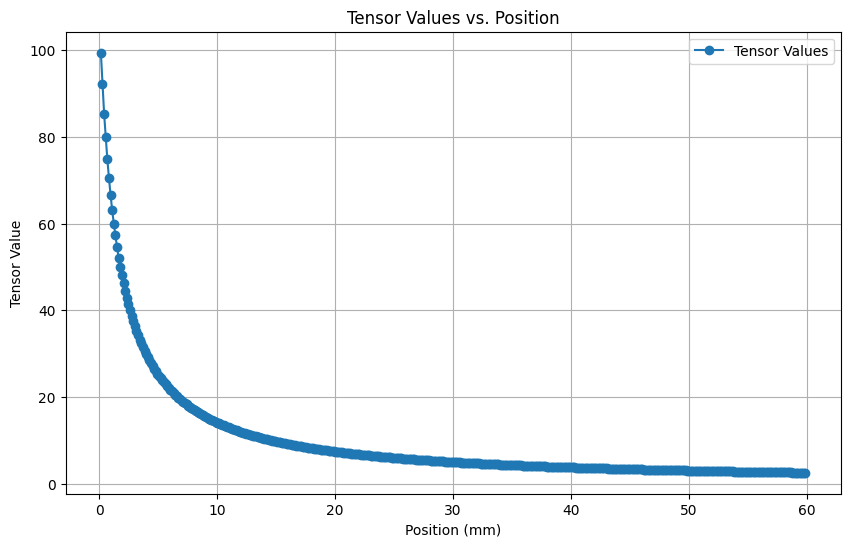

In [4]:
# The tensor provided
tensor_values = deflection_calc(1, 512, 64).squeeze()
# 
# # Remove leading zeros (presuming they are not part of the meaningful data)
nonzero_indices = torch.nonzero(torch.nan_to_num(tensor_values)).flatten()
nonzero_tensor_values = tensor_values[nonzero_indices[0]:]
# 
# # Calculate y-axis values in mm
pixel_in_mm = 0.137
y_values_mm = torch.arange(pixel_in_mm, pixel_in_mm*(len(nonzero_tensor_values)+1), pixel_in_mm)
# 
# # Plotting the tensor values
plt.figure(figsize=(10, 6))
plt.plot(y_values_mm, nonzero_tensor_values.numpy(), label='Tensor Values', marker='o')
# 
plt.xlabel('Position (mm)')
plt.ylabel('Tensor Value')
plt.title('Tensor Values vs. Position')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_1328098/1749186447.py:11: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x)
/tmp/ipykernel_1328098/1749186447.py:11: RuntimeWarning: overflow encountered in multiply
  return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x)
/tmp/ipykernel_1328098/1749186447.py:11: RuntimeWarning: invalid value encountered in add
  return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x)


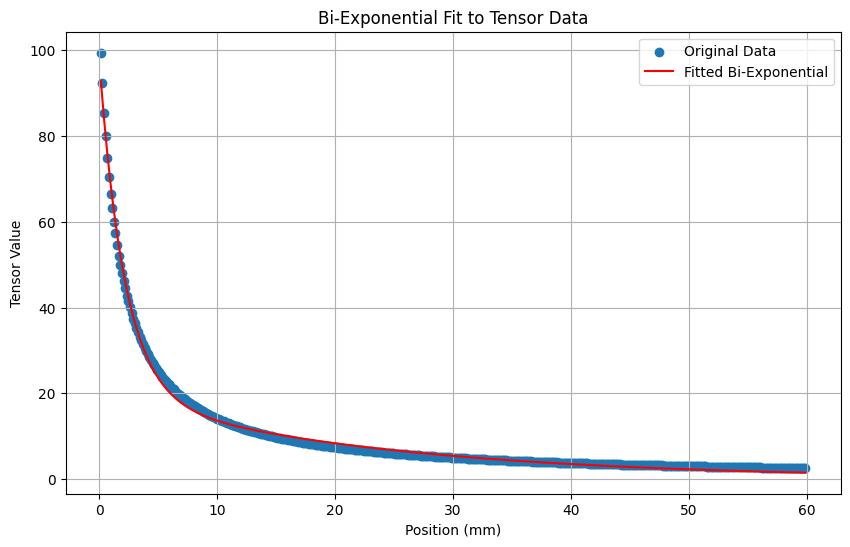

Fitted parameters: a1 = 77.85556860146512, b1 = 0.46648582290379326, a2 = 19.91175534082947, b2 = 0.043573073167125255


In [7]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_data and y_data are defined as in the previous step
x_data = y_values_mm.numpy() # Positions in mm
y_data = nonzero_tensor_values.numpy() # Tensor values

# Bi-exponential decay function
def bi_exponential(x, a1, b1, a2, b2):
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x)

# Fit the data to the bi-exponential function
# Initial guess values can significantly affect the outcome of the optimization,
# you might need to tweak these based on your data
# initial_guess = [20, 0.05, 78, 0.5]  # Example initial guesses for a1, b1, a2, b2
initial_guess = [1, 1, 1, 1]  # Example initial guesses for a1, b1, a2, b2
params, covariance = curve_fit(bi_exponential, x_data, y_data, p0=initial_guess)

# Extracted parameters
a1, b1, a2, b2 = params

# Generate fitted values
fitted_values = bi_exponential(x_data, *params)

# Plot original data and fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, fitted_values, label='Fitted Bi-Exponential', color='red')

plt.xlabel('Position (mm)')
plt.ylabel('Tensor Value')
plt.title('Bi-Exponential Fit to Tensor Data')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted parameters: a1 = {a1}, b1 = {b1}, a2 = {a2}, b2 = {b2}")
# a1 = 77.85556860146512, b1 = 0.46648582290379326, a2 = 19.91175534082947, b2 = 0.043573073167125255

